In [80]:
import seaborn as sns
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
pd.set_option("display.max_columns",80)
pd.set_option("display.max_rows",80)
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import tqdm as notebook_tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torch.utils.data import Dataset , DataLoader 
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as MSE 
from sklearn.metrics import mean_absolute_error as MAE
import neptune.new as neptune
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error, mean_poisson_deviance, mean_gamma_deviance
from torchvision.models.feature_extraction import create_feature_extractor,get_graph_node_names
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from scipy import special,stats



## EDA and Understanding the DATA

In [81]:
# Reading the data
attributes_df = pd.read_csv(r"C:\Users\nati\Desktop\Implementations\Assignment4-NLP\home-depot-product-search-relevance\attributes.csv\attributes.csv")
prod_desc_df = pd.read_csv(r"C:\Users\nati\Desktop\Implementations\Assignment4-NLP\home-depot-product-search-relevance\product_descriptions.csv\product_descriptions.csv")
sample_sub_df = pd.read_csv(r"C:\Users\nati\Desktop\Implementations\Assignment4-NLP\home-depot-product-search-relevance\sample_submission.csv\sample_submission.csv")
test_df = pd.read_csv(r"C:\Users\nati\Desktop\Implementations\Assignment4-NLP\home-depot-product-search-relevance\test.csv\test.csv",encoding="latin-1")
train_df = pd.read_csv(r"C:\Users\nati\Desktop\Implementations\Assignment4-NLP\home-depot-product-search-relevance\train.csv\train.csv",encoding="latin-1")

In [82]:
display(attributes_df.head(),prod_desc_df.head(),sample_sub_df.head(),test_df.head(),train_df.head())

,product_uid,name,value
0,100001.0,Bullet01,Versatile connector for various 90° connection...
1,100001.0,Bullet02,Stronger than angled nailing or screw fastenin...
2,100001.0,Bullet03,Help ensure joints are consistently straight a...
3,100001.0,Bullet04,Dimensions: 3 in. x 3 in. x 1-1/2 in.
4,100001.0,Bullet05,Made from 12-Gauge steel


,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


,id,relevance
0,1,1
1,4,1
2,5,1
3,6,1
4,7,1


,id,product_uid,product_title,search_term
0,1,100001,Simpson Strong-Tie 12-Gauge Angle,90 degree bracket
1,4,100001,Simpson Strong-Tie 12-Gauge Angle,metal l brackets
2,5,100001,Simpson Strong-Tie 12-Gauge Angle,simpson sku able
3,6,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong ties
4,7,100001,Simpson Strong-Tie 12-Gauge Angle,simpson strong tie hcc668


,id,product_uid,product_title,search_term,relevance
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67


In [83]:
train_df = pd.merge(prod_desc_df,train_df,left_on=prod_desc_df["product_uid"],right_on = train_df["product_uid"])
test_df = pd.merge(prod_desc_df,test_df,left_on=prod_desc_df["product_uid"],right_on = test_df["product_uid"])

In [99]:
def split_data(df,train_ratio):
    size = int(np.floor(train_ratio*len(df)))
    train_df = df[:size]
    val_df = df[size:]
    return train_df,val_df

def length_histogram(df,col):
# Length of characters per search phrase
    lengths = []
    for term in df[col]:
        lengths.append(len(term))
    print(f"Maximum searchterm Length is {max(lengths)}")
    print(f"Minimum searchterm Length is {min(lengths)}")
    print(f"Average searchterm Length is {np.mean(lengths)}")

    x,y = np.unique(lengths,return_counts=True)
    plt.title(f"{col} Length's Plot")
    plt.ylabel("Counts")
    plt.xlabel("Lengths")
    plt.bar(x,y,color = [0.99,0.7,0.3,0.7])

def create_feature_extractor(model, train_dataloader,device):
    # Iterate over batches
    output_list = []
    labels = []
    with torch.no_grad():
        for i, (title, term, label) in enumerate(train_dataloader, 0):
            title,term,label = title.to(device), term.to(device), label.to(device)
            output_1, output_2,pred = net(title.float(), term.float())
            output = torch.cat((output_1.detach().cpu(), output_2.detach().cpu()),dim=1)
            output = output.view(-1,32)
            output_list.append(output)
            labels.append(label.detach().cpu())

        output_list = torch.cat((output_list),dim=0)
        labels = torch.cat((labels),dim=0)
        final = torch.cat((output_list,labels), dim = 1)
        cols = [f"feature_{x}" for x in range(final.size(1))]
        cols[-1] = "Target"
    return pd.DataFrame(data = final.numpy(),columns=cols)

train_df , val_df = split_data(train_df,0.75)


<BarContainer object of 2 artists>

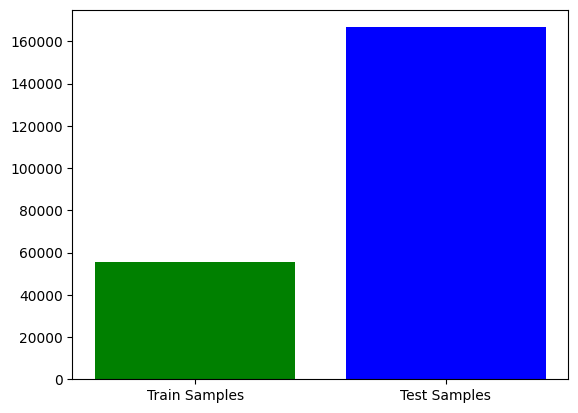

In [85]:
# Samples Count
plt.bar(x=["Train Samples","Test Samples"],height=[len(train_df),len(test_df)],color = ["green","blue"])

<AxesSubplot: title={'center': 'Train Balance Plot'}>

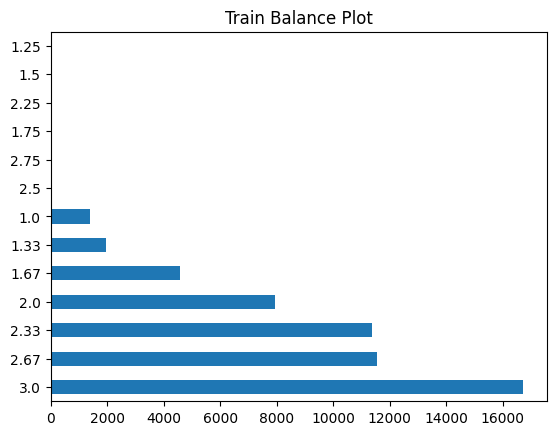

In [86]:
#Checking the balance of our dataset
train_df["relevance"].value_counts().plot(kind="barh",title="Train Balance Plot")

Maximum searchterm Length is 60
Minimum searchterm Length is 2
Average searchterm Length is 17.9414401440144


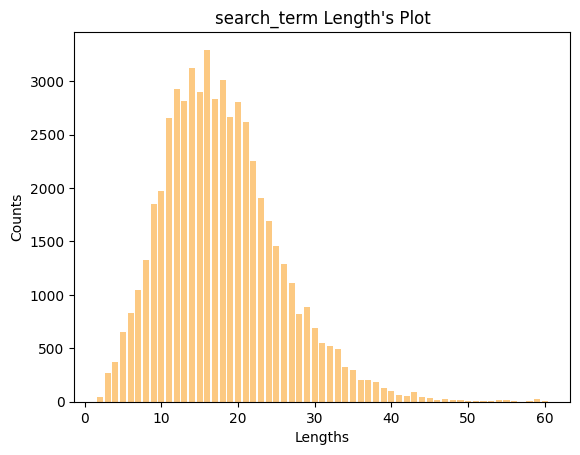

In [87]:
length_histogram(train_df,"search_term")

Maximum searchterm Length is 5516
Minimum searchterm Length is 153
Average searchterm Length is 896.2251305130513


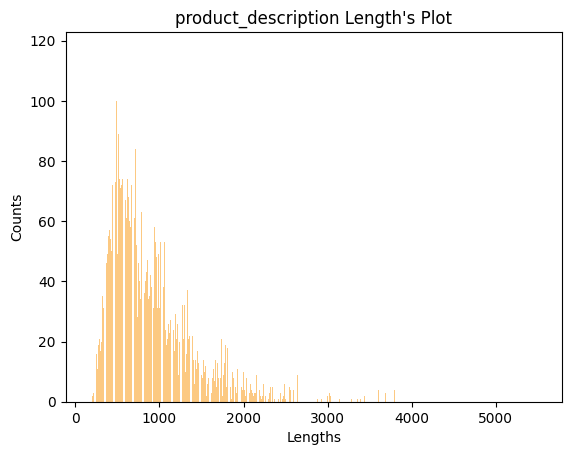

In [88]:
length_histogram(train_df,"product_description")

# 1)a. Preprocessing words to sequences of characters

In [89]:
import torch.nn.utils

def preprocess(data):
    # Convert the list of words into a sequence of characters
    first = torch.zeros(100)
    seq = [first]
    for sentence in data:
        characters = [ord(str.lower(x)) for x in sentence[:100] if x != " "]
        characters=torch.tensor(characters)
        seq.append(characters)

    padded = nn.utils.rnn.pad_sequence(seq,batch_first=True)
    print(padded.size())
    return padded

### 1.b Construct and train Siamese network (inputs are search term and product_titles and label is relevance (output of the network will be the
### predicted relevance))

In [91]:
def letter_percentage(df,col):
    sample = preprocess(df[col].to_numpy())
    sample = sample.flatten(0)
    sample = pd.DataFrame(sample.numpy(),columns = ["letter"])
    print(sample.value_counts(normalize=True)*100)
    

In [92]:
letter_percentage(train_df,"product_description")

torch.Size([55551, 100])
letter
0.0       15.860381
101.0      9.189466
116.0      7.019334
97.0       6.412414
105.0      6.354575
111.0      5.736242
114.0      5.591114
115.0      5.171194
110.0      5.113679
108.0      4.175784
104.0      3.233425
100.0      3.134255
99.0       2.961513
117.0      2.422315
112.0      1.996562
102.0      1.885493
109.0      1.875268
103.0      1.772803
119.0      1.349229
121.0      1.308707
98.0       1.265306
46.0       0.878400
118.0      0.805458
45.0       0.651869
107.0      0.642167
44.0       0.405537
120.0      0.353351
49.0       0.345448
48.0       0.313280
50.0       0.276035
52.0       0.179961
51.0       0.170888
53.0       0.133481
47.0       0.131015
113.0      0.122770
122.0      0.116686
56.0       0.116398
54.0       0.110403
106.0      0.088261
39.0       0.086821
55.0       0.056885
40.0       0.046912
57.0       0.043096
41.0       0.042393
38.0       0.009109
37.0       0.008875
43.0       0.007903
35.0       0.006607
34.0    

In [93]:

class SiameseDataset(Dataset):
    def __init__(self,train_df,train=True):
        self.train = train
        self.train_df = train_df
        self.product_titles_seq = preprocess(train_df["product_description"].to_numpy()).unsqueeze(2)
        self.search_terms_seq = preprocess(train_df["search_term"].to_numpy()).unsqueeze(2)
        if train:
            self.labels = torch.tensor(train_df["relevance"].to_numpy()).unsqueeze(1)

    def __len__(self):
        return len(self.train_df)

    def __getitem__(self,idx):
        if self.train:
            return self.product_titles_seq[idx],self.search_terms_seq[idx],self.labels[idx]
        else:
            return self.product_titles_seq[idx],self.search_terms_seq[idx]



train_dataloader = DataLoader(SiameseDataset(train_df=train_df),batch_size=256,shuffle=False)
valid_dataloader = DataLoader(SiameseDataset(train_df=val_df),batch_size=256,shuffle=False)


torch.Size([55551, 100])
torch.Size([55551, 100])
torch.Size([18518, 100])
torch.Size([18518, 100])


In [94]:
title,term,label = next(iter(train_dataloader))
title.shape,term.shape,label.shape

(torch.Size([256, 100, 1]), torch.Size([256, 100, 1]), torch.Size([256, 1]))

In [95]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self,n_hidden,n_layers,n_features):
        super(SiameseNetwork, self).__init__()
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.n_features = n_features
        # Setting up the Sequential of CNN Layers
        
        self.lstm = nn.LSTM(
            input_size = n_features,
            hidden_size = n_hidden,
            batch_first = True,
            num_layers = n_layers,
            bidirectional = True
        )
        
        self.regressor = nn.Linear(n_hidden,16)
        
    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        _,(h_n,_) = self.lstm(x)
        output = self.regressor(h_n[-1,:,:])
        # print(f"This is output fro regressor {output.shape}")
        return output
    

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        pred = F.cosine_similarity(output1,output2) + 2 
        return output1, output2, pred

# Define the Contrastive Loss Function as pytorch class
class ContrastiveLoss(torch.nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      cosine_similarity = F.cosine_similarity(output1,output2)
      loss_contrastive = torch.mean(label*torch.pow(1-cosine_similarity,2) + (3-label)*torch.pow(cosine_similarity,2))            
      return loss_contrastive

In [96]:
lr = 0.01
n_hidden = 16
n_layers = 1
n_features = 1
net = SiameseNetwork(n_hidden,n_layers,n_features).to(device=device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = lr)

In [57]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE

run = neptune.init_run(
    project="astarteam/PDLW-assignment-4",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3Y2Y1YTE5OC1hNzhhLTQwNjctYjgyZS03Y2Y1MzU5ZDg1YjYifQ==")
    
params = {"learning_rate": lr,'n_hidden': n_hidden,'n_layers':n_layers, 'n_features' :n_features,'sequence_length': title.size(1),
        'model':'LSTM with character level input'}

run["parameters"] = params
train_dataset_size = len(train_dataloader.dataset)
valid_dataset_size = len(valid_dataloader.dataset)

for epoch in range(5):
    train_loss, train_mse, train_mae,train_rmse,train_mape = 0, 0, 0,0,0
    val_loss, val_mse, val_mae, val_rmse,val_mape = 0, 0, 0, 0,0
    # train loop
    net.train()
    for i, (title, term, label) in enumerate(train_dataloader, 0):
        title,term,label = title.to(device), term.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2,pred = net(title, term)
        loss_contrastive = criterion(output1, output2, label)
        train_loss += loss_contrastive
        loss_contrastive.backward()
        optimizer.step()
        GT = label.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        train_mse += MSE(GT,pred)
        train_rmse += MSE(GT,pred, squared=True)
        train_mae += MAE(GT,pred)
        train_mape += MAPE(GT,pred)

        # Every 100 batches print out the loss
        if i % 100 == 0 :
            print(f"Epoch number {epoch}\n Current train loss {loss_contrastive.item()}\n")

    run["train/MSE"].log(train_mse/train_dataset_size)
    run["train/RMSE"].log(train_rmse/train_dataset_size)
    run["train/MAPE"].log(train_mape/train_dataset_size)
    run["train/MAE"].log(train_mae/train_dataset_size)
    run["train/loss"].log(train_loss/train_dataset_size)

    # validation loop
    with torch.no_grad():
        net.eval()
        for i, (title, term, label) in enumerate(valid_dataloader, 0):
            title, term, label = title.to(device), term.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2, pred = net(title.float(), term.float())
            loss_contrastive = criterion(output1, output2, label)
            val_loss += loss_contrastive
            GT = label.detach().cpu().numpy()
            pred = pred.detach().cpu().numpy()
            val_mse += MSE(GT,pred)
            val_rmse += MSE(GT,pred, squared=True)
            val_mae += MAE(GT,pred)
            val_mape += MAPE(GT,pred)
            # Every 100 batches print out the loss
            if i % 100 == 0 :
                print(f"Epoch number {epoch}\n Current validation loss {loss_contrastive.item()}\n")

        run["val/MSE"].log(val_mse/valid_dataset_size)
        run["val/RMSE"].log(val_rmse/valid_dataset_size)
        run["val/MAPE"].log(val_mape/valid_dataset_size)
        run["val/MAE"].log(val_mae/valid_dataset_size)
        run["val/loss"].log(val_loss/valid_dataset_size)

run.stop()

https://app.neptune.ai/astarteam/PDLW-assignment-4/e/PDLWAS1-49
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
Epoch number 0
 Current train loss 0.5671485660821118

Epoch number 0
 Current train loss 0.47927039684346295

Epoch number 0
 Current validation loss 0.4500130220033644

Epoch number 1
 Current train loss 0.4656061635311819

Epoch number 1
 Current train loss 0.47566309036122223

Epoch number 1
 Current validation loss 0.45002528559260224

Epoch number 2
 Current train loss 0.4642884063989835

Epoch number 2
 Current train loss 0.47599253724106805

Epoch number 2
 Current validation loss 0.45007843943826453

Epoch number 3
 Current train loss 0.46432275361486747

Epoch number 3
 Current train loss 0.47607192824536243

Epoch number 3
 Current validation loss 0.4500850726394351

Epoch number 4
 Current train loss 0.46433

In [58]:
run.stop()

## 1).c Naive Baseline Model

In [100]:
def plot_regression_metrics(ground_truth,preds):
    # Compute the mean absolute error
    mae = mean_absolute_error(ground_truth, preds)
    # Compute the mean squared error
    mse = mean_squared_error(ground_truth, preds)
    # Compute the R^2 score
    r2 = r2_score(ground_truth, preds)
    # Compute the explained variance score
    evs = explained_variance_score(ground_truth, preds)
    # Compute the maximum error
    max_err = max_error(ground_truth, preds)
    # Compute the mean Poisson deviance
    mpd = mean_poisson_deviance(ground_truth, preds)
    # Compute the mean Gamma deviance
    mgd = mean_gamma_deviance(ground_truth, preds)
    # Define the metric names and values
    metric_names = ['MAE', 'MSE', 'R2', 'EVS', 'Max Err', 'MPD', 'MGD']
    metric_values = [mae, mse, r2, evs, max_err, mpd, mgd]
    # Define a color scheme for the bars
    colors = ['#E64B35', '#4DBBD5', '#00A087', '#3C5488', '#FDB813', '#949494', '#D0D0D0']
    # Create a horizontal bar plot of the metrics
    fig, ax = plt.subplots(figsize=(12, 4))
    y_pos = np.arange(len(metric_names))
    ax.barh(y_pos, metric_values, align='center', color=colors)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(metric_names)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Value')
    ax.set_title('Regression Metrics')
    # Add the actual values to the bars
    for i, v in enumerate(metric_values):
        ax.text(v + 0.01, i, str(round(v, 3)), color='black', fontweight='bold')
    plt.show()

def plot_predicted_vs_actual(ground_truth,preds):
    # Create a line plot of the predicted and actual values
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(ground_truth, label='Actual', color='blue')
    ax.plot(preds, label='Predicted', color='green')
    ax.legend(loc='upper left')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Target')
    ax.set_title('Predicted vs Actual')
    plt.show()

def plot_scatter_predicted_vs_actual(ground_truth,preds):
    # Create a scatter plot of the predicted and actual values
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.scatter(range(len(ground_truth)), ground_truth, label='Actual', color='blue')
    ax.scatter(range(len(preds)), preds, label='Predicted', color='green')
    ax.legend(loc='upper left')
    ax.set_xlabel('Sample')
    ax.set_ylabel('Target')
    ax.set_title('Predicted vs Actual')
    plt.show()


In [102]:

#Creating N-Grams from characters
def n_grams(sentence, n):
    return [sentence[i:i+n] for i in range(len(sentence) - n + 1)]

# IOU - Intersection over Union
def jaccard_similarity(sentence1, sentence2, n):
    n_grams1 = set(n_grams(sentence1, n))
    n_grams2 = set(n_grams(sentence2, n))
    # print("N-gram1 : ",n_grams1,"N-gram2 : ", n_grams2)

    intersection = n_grams1.intersection(n_grams2)
    union = n_grams1.union(n_grams2)
    # print("Intersection : ",intersection,"Union : ", union)
    return len(intersection) / len(union)

def n_gram_base(df,n=2):
    preds = []
    ground_truth = []

    for description,term,relevance in tqdm(zip(df["product_description"],df["search_term"],df["relevance"])):
        similarity = jaccard_similarity(description,term,n=n)
        relevance_score = similarity*2 + 1
        preds.append(relevance_score)
        ground_truth.append(relevance)
    return preds,ground_truth



In [25]:
similarity = jaccard_similarity("haheha","hehahe",n=2)
print(similarity*2 + 1)

N-gram1 :  {'eh', 'ha', 'he', 'ah'} N-gram2 :  {'eh', 'ha', 'he', 'ah'}
Intersection :  {'eh', 'ha', 'he', 'ah'} Union :  {'ha', 'eh', 'ah', 'he'}
3.0


31246it [00:02, 10500.63it/s]


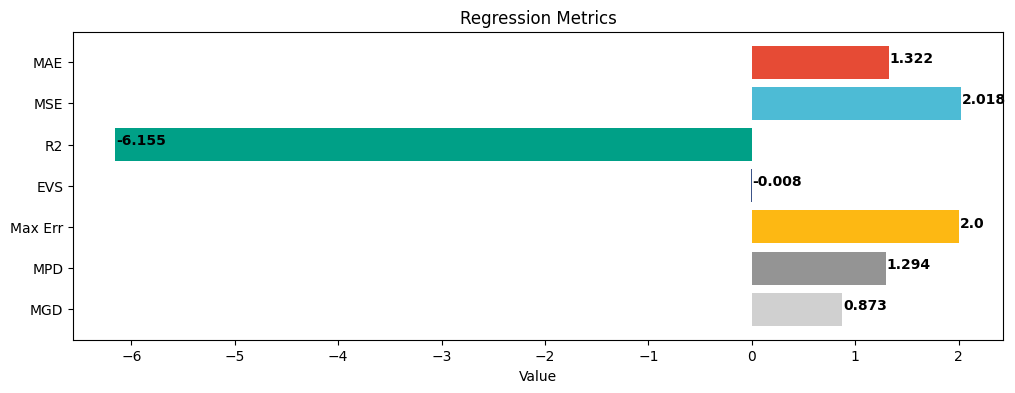

In [106]:
preds,ground_truth = n_gram_base(df=train_df,n =2)
plot_regression_metrics(ground_truth,preds)

# 1) d. Using memory embedding of the LSTM as feature as inputs for XGBoost and SVM

In [59]:
df = create_feature_extractor(model=net,train_dataloader=train_dataloader,device=device)
val_df  = create_feature_extractor(model=net,train_dataloader=valid_dataloader,device=device)
df.head()

In [62]:
X_train,y_train = df.iloc[:,:-1],df.iloc[:,-1]
X_val,y_val = val_df.iloc[:,:-1],val_df.iloc[:,-1]

Fitting 2 folds for each of 12 candidates, totalling 24 fits
Best parameters are: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}


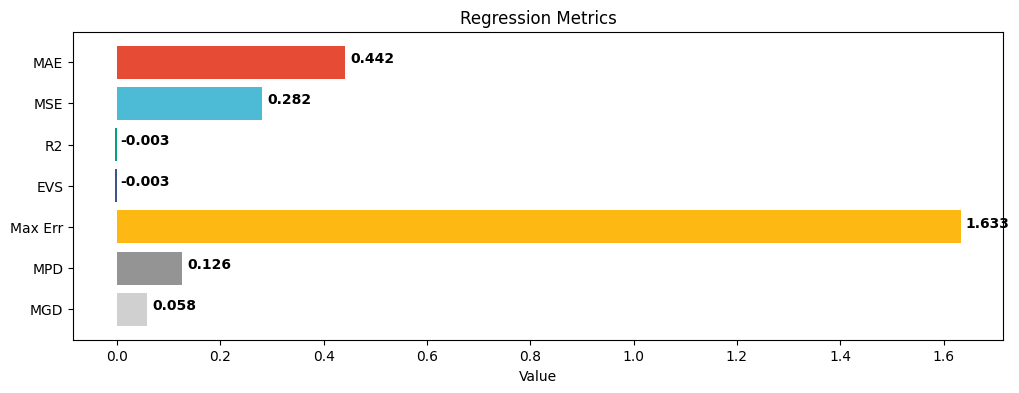

In [72]:
def grid_xgboost(X_train,y_train):
    # Define the model
    model = XGBRegressor()
    # Define the parameter grid to search over
    param_grid = {'n_estimators': [50, 100],'learning_rate': [0.01, 0.1, 0.3],'max_depth': [5, 7]}
    # Create the GridSearchCV object
    grid_search = GridSearchCV(model, param_grid, cv=2, n_jobs=-1,verbose=3)
    # Fit the GridSearchCV object to the data
    grid_search.fit(X_train, y_train)
    # Get the best model and its hyperparameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    print(f"Best parameters are: {best_params}")
    return best_model

model = grid_xgboost(X_train,y_train)
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_val)
# Evaluate the model
plot_regression_metrics(y_val,y_pred)

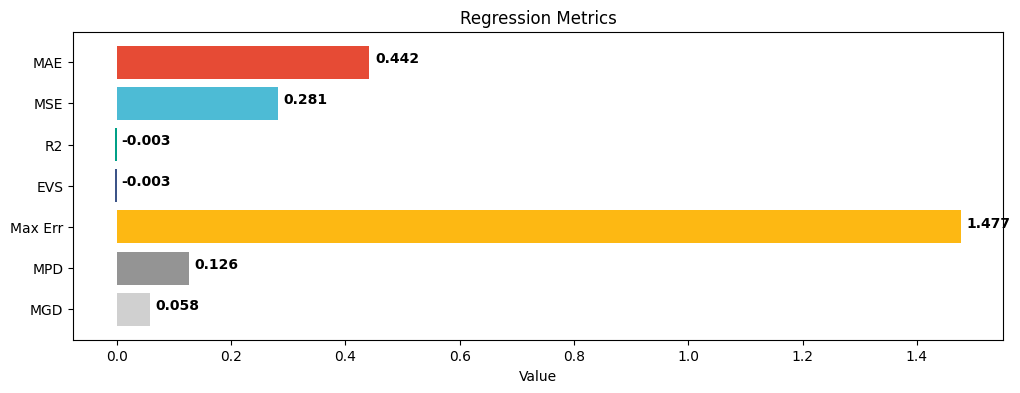

In [71]:
from sklearn.linear_model import LinearRegression

# Create a Linear Regression model
model = LinearRegression()
# Train the model on the training set
model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = model.predict(X_val)
# Evaluate the model
plot_regression_metrics(y_val,y_pred)

### Trying Target Transformation due to Imbalance ( We could also treat the problem as a classification
### problem, and we actually did try that but it did not show much improvement and didn't seem worth to continue
### The main benefit of treating it as a classification problem is that there are more ways to deal with imbalances
### on a classification tasks rather than regression tasks)

In [ ]:
class Transformer():
    def __init__(self):
        self._lambda = 0 # init lambda -> required for box cox inverse transformation
    
    def apply_transformation(self, data_in, transform_key):
        if transform_key == "no_transformation":
            data_transformed = data_in
        elif transform_key == "square_root":
            data_transformed = np.sqrt(data_in)
        elif transform_key == "log":
            data_transformed = np.log(data_in)
        elif transform_key == "boxcox":
            data_transformed, self._lambda = stats.boxcox(data_in)
        else:
            raise ValueError(f"{transform_key} is an invalid option!")
        
        return data_transformed
    
    def apply_inverse_transformation(self, data_in, transform_key):
        if transform_key == "no_transformation":
            data_transformed = data_in
        elif transform_key == "square_root":
            data_transformed = data_in**2
        elif transform_key == "log":
            data_transformed = np.exp(data_in)
        elif transform_key == "boxcox":
            data_transformed = special.inv_boxcox(data_in, self._lambda)
        else:
            raise ValueError(f"{transform_key} is an invalid option!")
        
        return data_transformed


        
# iterate over different transformations and train model plus get error
transformations_list = ["no_transformation","square_root","log","boxcox"]
results_dict = {}
for transformation in transformations_list:
    transformer = Transformer()
    y_train_transformed = transformer.apply_transformation(y_train, transformation)
    # create linear regression model and train
    model = grid_xgboost(X_train,y_train_transformed)
    # create predictions on test set
    preds = model.predict(X_val)
    # transform back
    preds = transformer.apply_inverse_transformation(preds, transformation)
    # get mse and r2
    r2 = r2_score(y_val, preds)
    mse = mean_squared_error(y_val, preds)
    # store in results dict
    results_dict[transformation] = [r2, mse]

df_results = pd.DataFrame.from_dict(results_dict, orient="index", columns=["R2-Score", "MSE"])
print(df_results)

# Section 2

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from gensim.models import Word2Vec
import numpy as np
import gensim 
from gensim import corpora
import logging
import torch.nn.utils
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

In [108]:
def preprocess_words(data, stoplist=None, sentence_size= 10, min_freq=1):
    # remove common words and tokenize
    if stoplist == None:
        stoplist = set(ENGLISH_STOP_WORDS)
    texts = [[word for word in document.lower().split() if word not in stoplist] for document in data]

    # remove words that appear only once
    from collections import defaultdict
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1

    texts = [[token for token in text if frequency[token] > min_freq]
            for text in texts]
    return texts

In [109]:
product_description = preprocess_words(train_df['product_description'])
search_term  = preprocess_words(train_df['search_term'])

In [110]:
# Load and preprocess your text data as needed
vector_size= 50
# Train a Word2Vec model on your preprocessed text data to generate word embeddings
texts = product_description + search_term
model = gensim.models.Word2Vec(texts,vector_size=vector_size,window=10,min_count=1,workers=10)
model.train(texts, total_examples=len(texts), epochs=10)

2023-02-21 22:29:34,237 : INFO : collecting all words and their counts
2023-02-21 22:29:34,238 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2023-02-21 22:29:34,332 : INFO : PROGRESS: at sentence #10000, processed 986933 words, keeping 46321 word types
2023-02-21 22:29:34,441 : INFO : PROGRESS: at sentence #20000, processed 1897452 words, keeping 71031 word types
2023-02-21 22:29:34,547 : INFO : PROGRESS: at sentence #30000, processed 2792105 words, keeping 85308 word types
2023-02-21 22:29:34,569 : INFO : PROGRESS: at sentence #40000, processed 2925114 words, keeping 87643 word types
2023-02-21 22:29:34,578 : INFO : PROGRESS: at sentence #50000, processed 2953416 words, keeping 88199 word types
2023-02-21 22:29:34,584 : INFO : PROGRESS: at sentence #60000, processed 2981651 words, keeping 88355 word types
2023-02-21 22:29:34,587 : INFO : collected 88361 word types from a corpus of 2988719 raw words and 62492 sentences
2023-02-21 22:29:34,587 : INFO : Creat

(29151014, 29887190)

In [111]:
# Define a custom PyTorch dataset to preprocess and load your text data
class WordDataset(Dataset):
    def __init__(self, df,train=True, stoplist=None, sentence_size= 10):
        self.df = df
        self.text1 = preprocess_words(df["product_description"])
        self.text2 = preprocess_words(df["search_term"])
        self.sentence_size = sentence_size
        if stoplist == None:
            self.stoplist = set(ENGLISH_STOP_WORDS)
        if train:
            self.labels = (torch.tensor(df["relevance"].to_numpy()).unsqueeze(1) - 1)/2 # Normalizing between 0 and 1

    def __len__(self):
        return len(self.labels)
    
    def words2batch(self, words):     
        if len(words) > self.sentence_size:
            words= words[:self.sentence_size]
            words = torch.tensor([model.wv[token] for token in words])
        else:
            words = torch.tensor([model.wv[token] for token in words])
            pading_size = self.sentence_size - words.size(0)
            words = torch.cat((words, torch.zeros(pading_size,50)))

                
        return words

    def __getitem__(self, index):
        label = self.labels[index]
        input1 = self.words2batch(self.text1[index])
        input2 = self.words2batch(self.text2[index])
        
        return input1, input2, label

In [112]:
# Define a Siamese neural network architecture using PyTorch with LSTM layers
class SiameseNetwork(nn.Module):
    def __init__(self, embedding_size=50, hidden_size=32, layers=1):
        super(SiameseNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size=embedding_size,hidden_size=hidden_size,num_layers=layers, batch_first=True, bidirectional = True)
        self.regressor = nn.Linear(hidden_size, 16)

    def forward(self, input1, input2):
        hidden_features1, (h_n1, _) = self.lstm(input1)
        hidden_features2, (h_n2, _)= self.lstm(input2)
        lstm1 = self.regressor(h_n1[-1])
        lstm2 = self.regressor(h_n2[-1])
        output = F.cosine_similarity(lstm1,lstm2)+ 2
        return lstm1, lstm2, output

In [113]:
lr = 0.001
n_hidden = 128
n_layers = 4
sentence_size = 30
n_featur = vector_size
network = SiameseNetwork(embedding_size=n_featur, hidden_size=n_hidden,layers=n_layers).to(device=device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(network.parameters(), lr = lr )

train_dataloader = DataLoader(WordDataset(df=train_df,sentence_size=sentence_size ),batch_size=256,shuffle=False)
val_dataloader = DataLoader(WordDataset(df=val_df, sentence_size=sentence_size),batch_size=256,shuffle=False)

In [ ]:
lr = 0.0001
n_hidden = 128
n_layers = 2
sentence_size = 40
n_feature = vector_size
network = SiameseNetwork(embedding_size=n_feature, hidden_size=n_hidden,layers=n_layers).to(device=device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(network.parameters(), lr = lr )

train_dataloader = DataLoader(WordDataset(df=train_df,sentence_size=sentence_size ),batch_size=256,shuffle=False)
val_dataloader = DataLoader(WordDataset(df=val_df, sentence_size=sentence_size),batch_size=256,shuffle=False)

run = neptune.init_run(
    project="astarteam/PDLW-assignment-4",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials


params = {"learning_rate": lr,'n_hidden': n_hidden, 
        'n_layers':n_layers, 'n_featur' :n_feature,
        'sentence size': sentence_size,
        'model':'LSTM with word level input'}

run["parameters"] = params
dataset_size = len(train_dataloader.dataset) 
for epoch in range(8):
    train_loss, train_mse, train_mae,train_rmse,train_mape = 0, 0, 0,0,0
    val_loss, val_mse, val_mae, val_rmse,val_mape = 0, 0, 0, 0,0
    # train loop
    network.train()
    for i, (title, term, label) in enumerate(train_dataloader, 0):
        title,term,label = title.to(device), term.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2,pred = network(title, term)
        loss_contrastive = criterion(output1, output2, label)
        train_loss += loss_contrastive
        loss_contrastive.backward()
        optimizer.step()
        GT = label.detach().cpu().numpy()
        pred = pred.detach().cpu().numpy()
        train_mse += MSE(GT,pred)
        train_rmse += MSE(GT,pred, squared=True)
        train_mae += MAE(GT,pred)
        train_mape += MAPE(GT,pred)

        # Every 100 batches print out the loss
        if i % 100 == 0 :
            print(f"Epoch number {epoch}\n Current train loss {loss_contrastive.item()}\n")

    run["train/MSE"].log(train_mse/dataset_size)
    run["train/RMSE"].log(train_rmse/dataset_size)
    run["train/MAPE"].log(train_mape/dataset_size)
    run["train/MAE"].log(train_mae/dataset_size)
    run["train/loss"].log(train_loss/dataset_size)

    # validation loop
    with torch.no_grad():
        network.eval()
        for i, (title, term, label) in enumerate(val_dataloader, 0):
            title, term, label = title.to(device), term.to(device), label.to(device)
            optimizer.zero_grad()
            output1, output2, pred = network(title.float(), term.float())
            loss_contrastive = criterion(output1, output2, label)
            val_loss += loss_contrastive
            GT = label.detach().cpu().numpy()
            pred = pred.detach().cpu().numpy()
            val_mse += MSE(GT,pred)
            val_rmse += MSE(GT,pred, squared=True)
            val_mae += MAE(GT,pred)
            val_mape += MAPE(GT,pred)
            # Every 100 batches print out the loss
            if i % 100 == 0 :
                print(f"Epoch number {epoch}\n Current validation loss {loss_contrastive.item()}\n")

        run["val/MSE"].log(val_mse/dataset_size)
        run["val/RMSE"].log(val_rmse/dataset_size)
        run["val/MAPE"].log(val_mape/dataset_size)
        run["val/MAE"].log(val_mae/dataset_size)
        run["val/loss"].log(val_loss/dataset_size)

run.stop()

In [114]:
def create_feature_extractor_b(model,regerror_out, train_dataloader,device):
    # Iterate over batches
    output_list = []
    labels = []
    with torch.no_grad():
        for i, (title, term, label) in enumerate(train_dataloader, 0):
            title,term,label = title.to(device), term.to(device), label.to(device)
            output_1, output_2, _ = model(title.float(), term.float())
            output = torch.cat((output_1.detach().cpu(), output_2.detach().cpu()),dim=1)
            output = output.view(-1,regerror_out)
            output_list.append(output)
            labels.append(label.detach().cpu())

        output_list = torch.cat((output_list),dim=0)
        labels = torch.cat((labels),dim=0)
        final = torch.cat((output_list,labels), dim = 1)
        cols = [f"feature_{x}" for x in range(final.size(1))]
        cols[-1] = "Target"
    return pd.DataFrame(data = final.numpy(),columns=cols)

In [115]:
train_ext_feature = create_feature_extractor_b(network,regerror_out=32, train_dataloader=train_dataloader, device=device)
val_ext_feature = create_feature_extractor_b(network,regerror_out=32, train_dataloader=train_dataloader, device=device)

In [116]:
X_train, y_train = train_ext_feature.drop(columns=['Target']), train_ext_feature['Target']
X_val, y_val = val_ext_feature.drop(columns=['Target']), val_ext_feature['Target']

In [ ]:
import xgboost as xgb
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance

In [ ]:
xgb_model = grid_xgboost(X_train,y_train)
preds = xgb_model.predict(X_train)
plot_regression_metrics(y_train,preds, 'Train')
val_preds = xgb_model.predict(X_val)
plot_regression_metrics(y_val,val_preds, 'Validation')

In [ ]:
catboost = cb.CatBoostRegressor(loss_function='RMSE')
parameters = {'depth': [6, 8, 10],
              'learning_rate': [0.01, 0.05],
              'iterations': [100, 500]}

search = GridSearchCV(catboost, parameters, cv=2).fit(X_train, y_train)


print("Best parameters found: ", search.best_params_)
print("Best accuracy: ", search.best_score_)

In [ ]:
preds = search.best_estimator_.predict(X_train)
plot_regression_metrics(y_train,preds, 'Train')
val_preds = search.best_estimator_.predict(X_val)
plot_regression_metrics(y_val,val_preds, 'Validation')

In [ ]:
from catboost import Pool
C:\Users\nati\Desktop\Implementations\Assignment4-NLP\Assignment4.ipynb

In [ ]:
model = cb.CatBoostRegressor(depth= 10, iterations=500, learning_rate=0.05 ,loss_function='RMSE')
# define the datasets to evaluate each iteration
evalset = [(X_train, y_train), (X_val,y_val)]
# fit the model
model.fit(X_train, y_train, eval_metric='rmse', eval_set=evalset)
# evaluate performance
yhat = model.predict(X_val)
# score = accuracy_score(y_test, yhat)
# print('Accuracy: %.3f' % score)
# retrieve performance metrics
results = model.evals_result()
# plot learning curves
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')

plt.title('Learning Curves')
plt.legend()
plt.show()